In [1]:
import algorithms.train as train
import algorithms.utils as utils
import algorithms.models as models
from enviroments import env_red, env_red_p2p, env_red_toy1, env_hubs1, env_hubs2,env_hubs3, env_red_toy3
from algorithms.agents import reinforce, trpo, ppo
import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import time
import pickle

In [3]:
name_exp = "Exp25"
Red_name = "hub3"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "NN-PG-a5" #Puede ser LR/NN

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
env = env_hubs3()
M = 6
F = 2

#Dimensiónes del espacio de estados
dims_state = list(env.C + 1)
dims_state.append(env.T+1)

#Dimensiones del espacio de acciones
dims_action = [M, F]


In [5]:
actor = models.PolicyNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[128, 128], 
    num_outputs= [2**(env.J)], 
    model="Softmax"
).double().to(device)

critc = models.ValueNetwork(
    num_inputs=len(dims_state), 
    num_hiddens=[128, 128], 
    num_outputs=1, 
).double().to(device)

Trainer = train.Trainer("sgd", "sgd")

re_agent = reinforce.ReinforceSoftmaxNN(actor, critc, gamma=.99, tau=.99, lr_actor= 1e-5,device=device)
trpo_agent = trpo.TRPOSoftmaxNN(actor, critc, gamma=.999, tau=.999, delta=.01, cg_dampening=0.3, cg_tolerance=1e-10, cg_iteration=15,device=device)
ppo_agent = ppo.PPOSoftmaxNN(actor, critc,gamma=1, tau=1, lr_actor=1e-3, epochs=100, betha=1e-3,eps_clip=0.1,device=device)


In [6]:
R_exp = []
time_exp = []
qfun_exp = []
pg_model = []

PG_MODEL = "PPO"
epochs=60000
max_steps=2000
update_freq=5000
initial_offset=0

if PG_MODEL == "Reinforce":
    start_time = time.time()
    agent, totals,_ = Trainer.train(env, re_agent, epochs, max_steps, update_freq, initial_offset)
    end_time = time.time()
    execution_time = end_time - start_time

elif PG_MODEL == "TRPO":
    start_time = time.time()
    agent, totals,_ = Trainer.train(env, trpo_agent, epochs, max_steps, update_freq, initial_offset)
    end_time = time.time()
    execution_time = end_time - start_time

elif PG_MODEL == "PPO":
    start_time = time.time()
    agent, totals,_ = Trainer.train(env, ppo_agent, epochs, max_steps, update_freq, initial_offset)
    end_time = time.time()
    execution_time = end_time - start_time

pg_model.append(PG_MODEL)
R_exp.append(totals)
time_exp.append(execution_time)
qfun_exp.append(agent)

tensor([58], device='cuda:0')
tensor([36], device='cuda:0')
tensor([24], device='cuda:0')
tensor([43], device='cuda:0')
tensor([38], device='cuda:0')
tensor([26], device='cuda:0')
tensor([63], device='cuda:0')
tensor([16], device='cuda:0')
tensor([5], device='cuda:0')
tensor([57], device='cuda:0')
tensor([54], device='cuda:0')
tensor([35], device='cuda:0')
tensor([0], device='cuda:0')
tensor([24], device='cuda:0')
tensor([5], device='cuda:0')
tensor([45], device='cuda:0')
tensor([17], device='cuda:0')
tensor([14], device='cuda:0')
tensor([53], device='cuda:0')
tensor([36], device='cuda:0')
tensor([62], device='cuda:0')
tensor([50], device='cuda:0')
tensor([12], device='cuda:0')
tensor([24], device='cuda:0')
tensor([56], device='cuda:0')
tensor([22], device='cuda:0')
tensor([30], device='cuda:0')
tensor([33], device='cuda:0')
tensor([14], device='cuda:0')
tensor([57], device='cuda:0')
tensor([60], device='cuda:0')
tensor([33], device='cuda:0')
tensor([37], device='cuda:0')
tensor([9], d

KeyboardInterrupt: 

In [7]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)

exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qfun_exp
exp["PG_model"] = pg_model

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [ ]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)

exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qfun_exp
exp["PG_model"] = pg_model

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [4]:
with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]
qfun_exp = exp["qfun_exp"] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


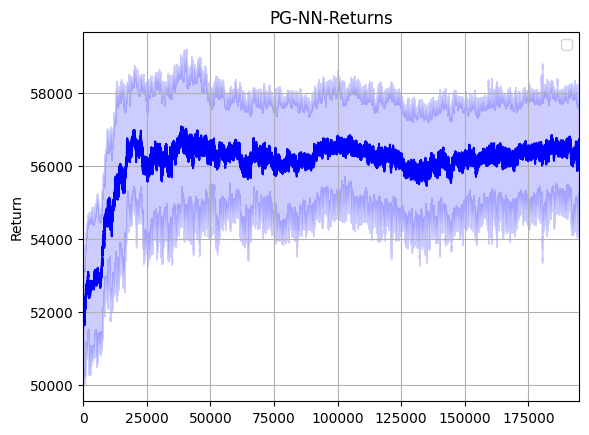

In [5]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(1)

Rs = np.array(R_exp[0]).ravel()

mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
time = np.arange(mean.size)
plt.plot(mean,color='b')
#plt.plot(Rsim, color = 'r')
plt.fill_between(time, mean - std, mean + std, color='b', alpha=0.2)

plt.xlim(0, len(Rs))
plt.grid()
plt.ylabel("Return")
plt.legend()
plt.title("PG-NN-Returns")
    
plt.savefig("results/"+ name_exp + "/Returns_" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

In [7]:
env = env_red_toy3(model="Exp",T=30)
num_sim = 1000
max_steps = env.T

Rs = []
R_t= []
S_sf = []
Num_politicas = 4

for p in range(Num_politicas):
    rs = []
    s_t = []
    r_t = []
    s_sf = []
    for episode in range(num_sim):
        s, _ = env.set_initial(s = [0]*env.I)
        R = 0
        for step in range(max_steps):

            if p == 0:
                a = [1,1,0]
            elif p == 1:
                a = [1,1,1]
            elif p == 2:
                a = list(np.random.choice([0, 1], size=3))
            elif p == 3:
                a = qfun_exp[0].policy.pi(s).sample().cpu()
            #print(p)
            s_prime, r, done, _, _ = env.step(a)
   
            r_t.append(r)
            s_t.append(s)

            R += r

            if done:
                S = s_prime
                break
            s = s_prime    
        rs.append(R)
        s_sf.append(S)
    S_sf.append(s_sf)
    Rs.append(rs)

[28.702, 20.231, 28.509, 28.598]
[1757.5, 1546.1, 1305.3, 1752.7]


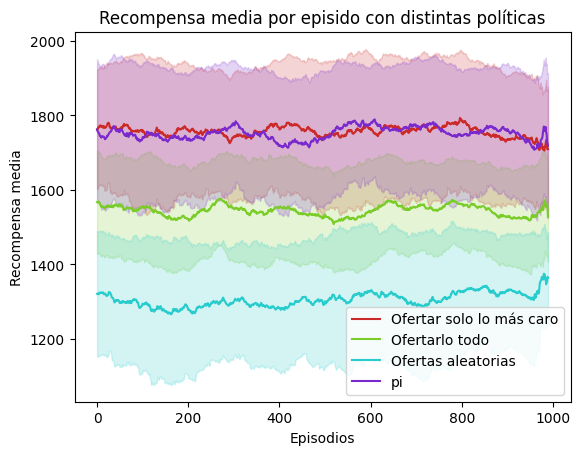

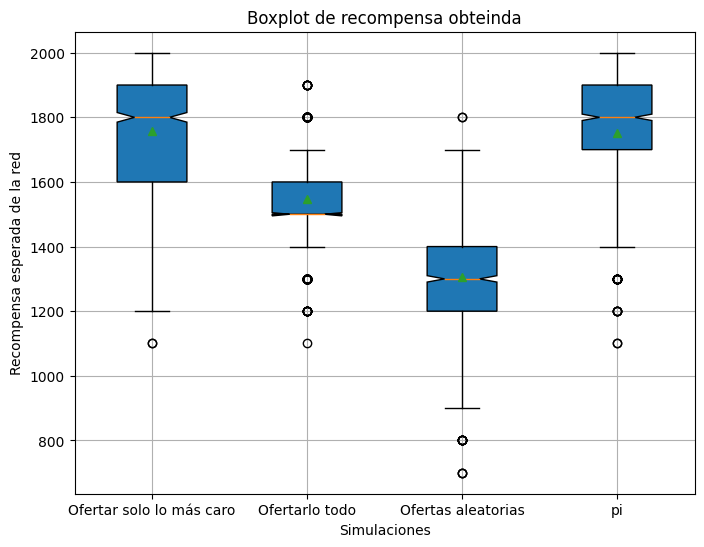

In [8]:
from algorithms.utils import generate_random_colors

colors = generate_random_colors(Num_politicas)
etiqueta =  ["Ofertar solo lo más caro", "Ofertarlo todo", "Ofertas aleatorias","pi"]

for p in range(Num_politicas):
    
    totals = Rs[p]
    x = np.array(totals).ravel()

    mean = np.array([np.mean(x[i:i+100]) for i in range(len(x) - 10)])
    std = np.array([np.std(x[i:i+100]) for i in range(len(x) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[p],label = etiqueta[p])
    #plt.plot(Rsim, color = 'r')
    plt.fill_between(time, mean - std, mean + std, color=colors[p], alpha=0.2)
    plt.title("Recompensa media por episido con distintas políticas")
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.legend()
    

T_tf_mean = []
for i in range(Num_politicas):
    t_tf = []
    for x in S_sf[i]:
        t_tf.append(x[2])
    T_tf_mean.append(np.mean(t_tf))

print(T_tf_mean)

Rs_f_mean = []
for i in range(Num_politicas):
    Rs_f_mean.append(np.mean(Rs[i]))

print(Rs_f_mean)

datos = Rs
plt.figure(figsize=(8, 6))
plt.boxplot(datos, patch_artist=True, notch=True, showmeans=True)

plt.title('Boxplot de recompensa obteinda')
plt.xlabel('Simulaciones')
plt.ylabel('Recompensa esperada de la red')
plt.xticks(range(1,Num_politicas+1),etiqueta)  # Cambiar etiquetas del eje x
plt.grid(True)
plt.savefig("results/"+ name_exp +"/BoxPlot_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")


In [10]:
np.mean(Rs[3])

1752.7